<a href="https://colab.research.google.com/github/CS-Edwards/vector_search_engine/blob/main/CEdwards_ICS691B_Final_Weaviate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Weaviate Review

Introduction

## Architecture Overview

The image below is a diagram of ‘Weaviate’s System Level Overview (Example with two modules)' sourced from Weaviate’s [documentation](https://weaviate.io/developers/weaviate/current/architecture/index.html). In this section, the diagram will guide the discussion of Weaviate’s architectural components. This section covers the following portions of the diagram: Modules, API and Persistence. Business logic is excluded from the discussion, as it is not relevant to our demonstration.

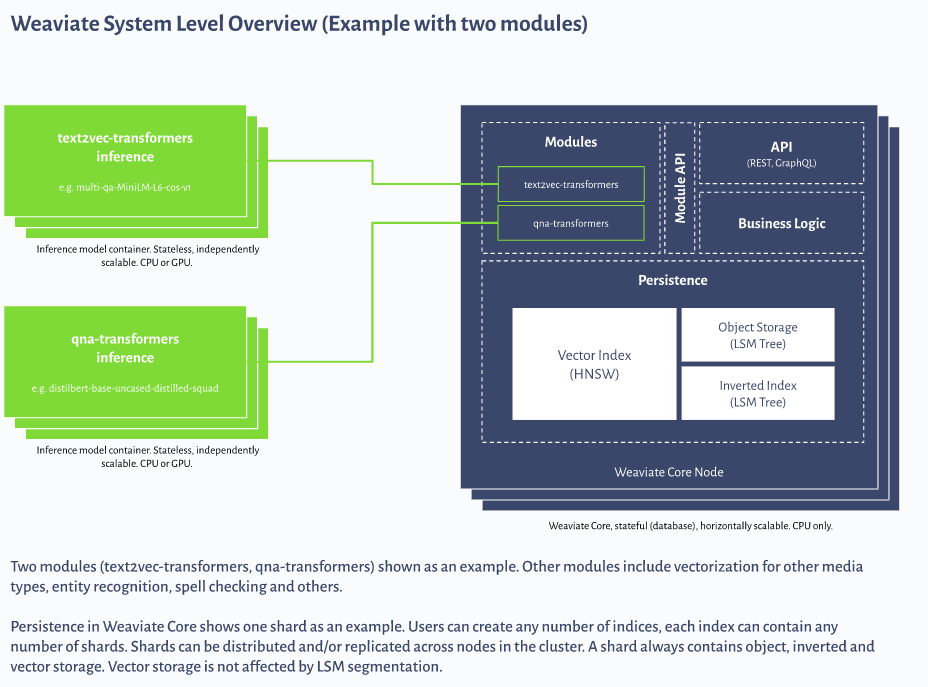

### Modules

Weavaite provides several dense retriever modules out of the box that can be used to vectorize data. Both text and images can be vectorized using the modules. Weaviate’s vectorization modules currently include: `text2vec-openai`, `text2vec-huggingface`, `text2vec-transformers`, `text2vec-contextionary`,`img2vec-neural`, `multi2vec-clip`, `ref2vec-centroid`.  The contextionary module is Weaviate’s own Weighted Mean of Word Embeddings vectorizer that creates a 300-dimensional space embedding. Other modules offer the integration of popular external models. For example, `text2vec-huggingface`, allows Hugging Face models to be integrated directly into Weaviate as the vectorizer. 


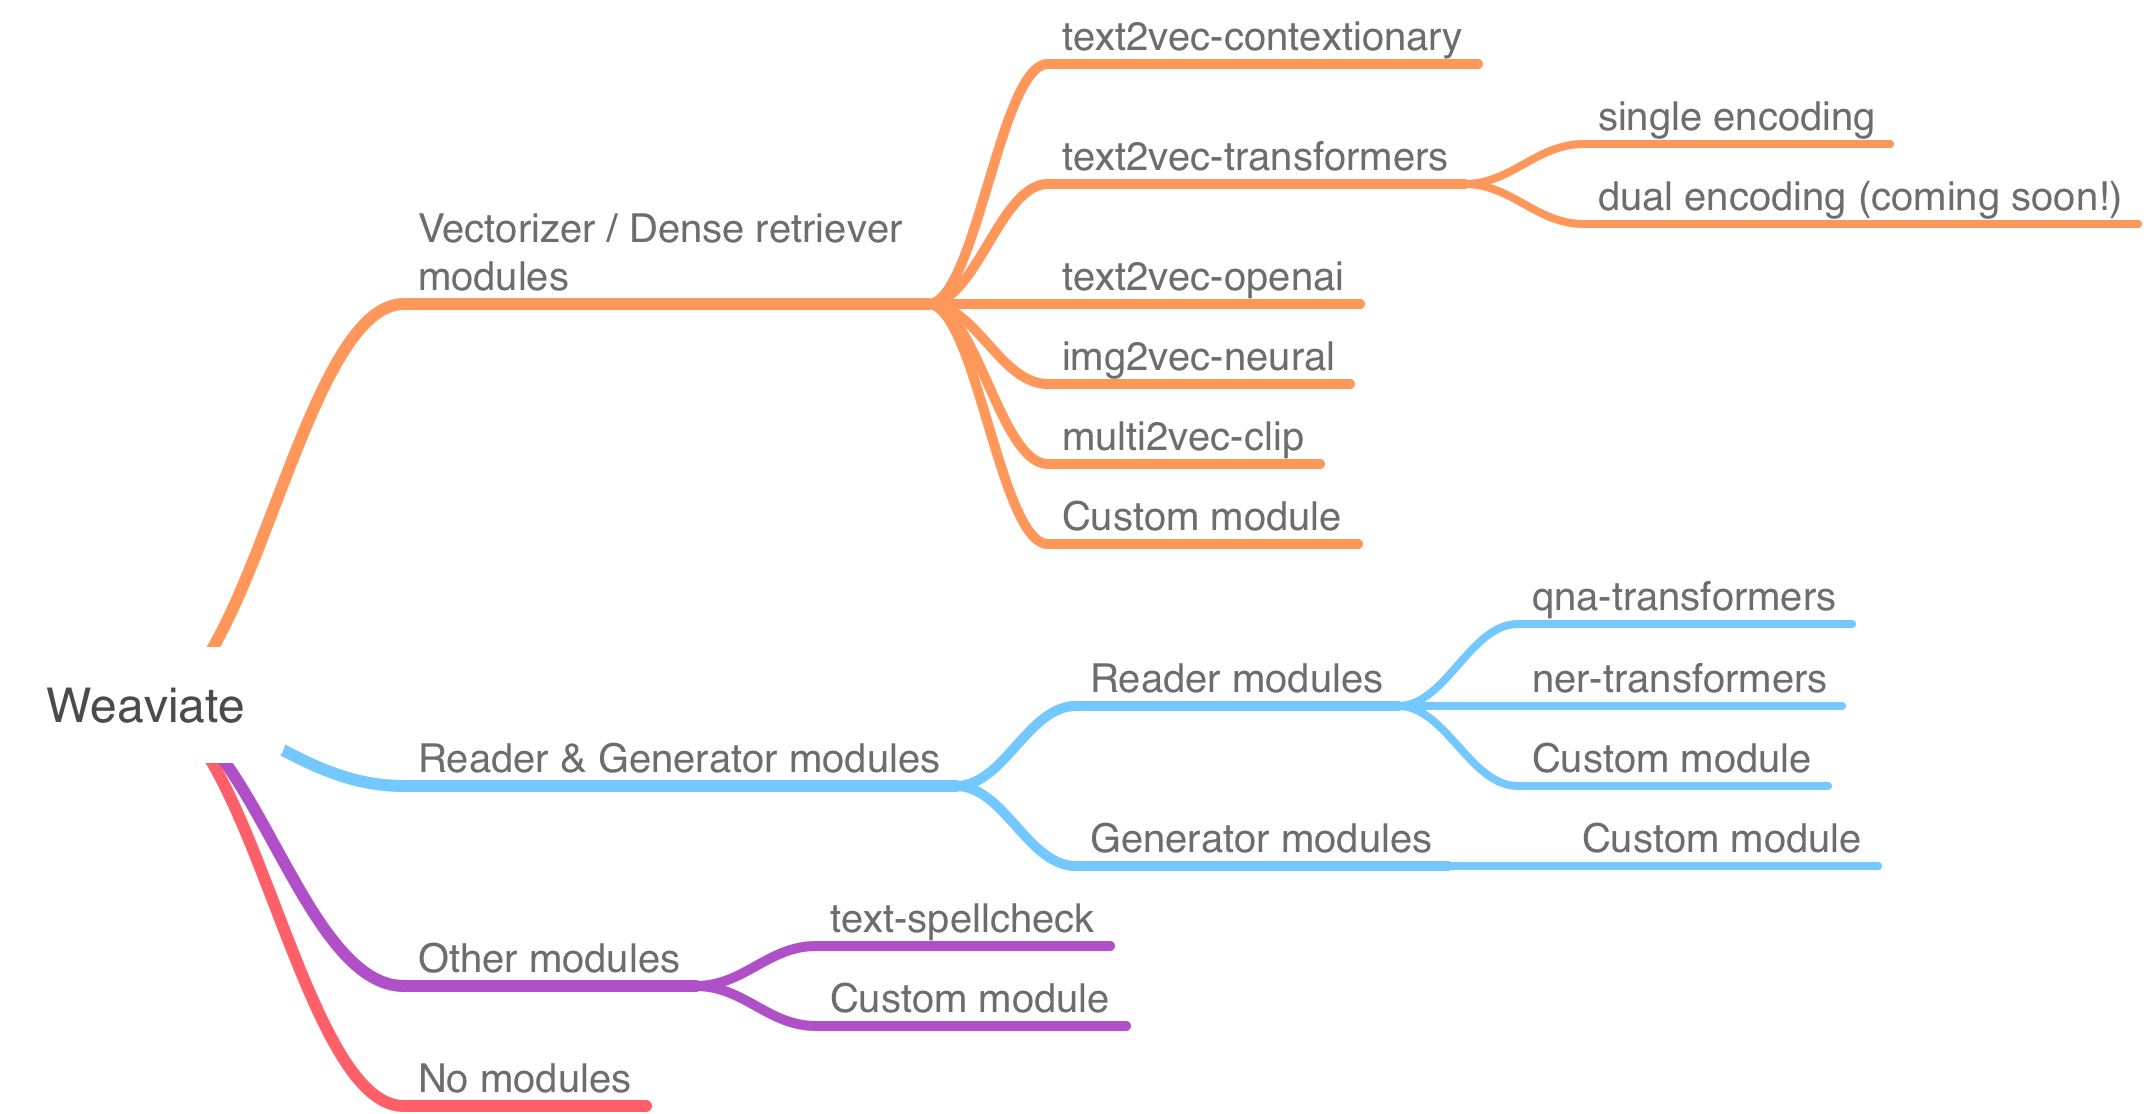

To date, `text2vec-openai`, and `text2vec-huggingface` are the only modules available (enabled) on the Weaviate Cloud Service. 

Additional modules can be used with vectorizer modules to provide further functionality in the vector database including: Question Answering, Name Entity Recognition and Summarization. Weavaite also allows for the integration of custom modules written in Go. 

**Weaviate can be used without any modules as a pure vector-native database and search engine. In this case the user must provide the vector.** 

**In our implementation of the Weaviate database, we generate our own vectors and load them into the database with the object.**


### APIs and the Weaviate Console:
Weaviate utilizes both a RESTful API and GraphQL API. The GraphQL API is used for: data search, explorative data search and meta-data analysis, while RESTful API is used for CRUD operations and Weaviate management operations. Weaviates support client libraries (Python, Java, Go and JavaScript) use both APIs ‘under the hood’.

GraphQL is the query language used to interact with Weaviate instances. According to the interface [documentation](https://weaviate.io/developers/weaviate/current/architecture/interface.html), the natural language structure of GraphQL queries, the Class and properties structure of the Weaviate data and the query filtering abilities were the key UX design considerations taken into account when developing the interface. The GraphQL design support three main functions : <br>


`Get{}` : for data search when the class name is known <br>
`Explore{}`:  to ‘fuzzy search’ when the schema and class names are unknown <br>
`Aggregate{}`: to search for metadata and do data analysis of data aggregations <br>

The Weaviate Console is a dashboard to manage clusters from the Weaviate Cloud Service. Within the Weaviate Console, the Query Module can be used to make GraphQL queries on Weaviate instances. <br>

<b> Note: In our demonstration we use the Python client to query the data. The query in Python is translated into a GraphQL query. </b>


### Persistence:


A Weaviate shard contains an object store, an inverted index and an index vector store. Weaviate allows for pre-filtered metadata search using the inverted index, and returns full objects stored in the object store. The HNSW graph is stored in the index vector store, and is discussed in detail later in this project. 

Both the object and inverted index use a Log-Structured Merge (LSM) Tree approach. LSM Trees allow for constant, O(1), data inserts by batch sequential writes of sorted data to disk. For read requests, the current memtable (in memory) is checked for the requested object. If the object is not present in the memtable, previously written segments (on disk) are checked in order of most current to ascending aged segments. Bloom filters are used to reduce accesses to segments that do not contain the object being queried. In short, if the Bloom filter key hash result is zero, the object is not present in the segment and the segment is not searched. Overall the LSM Tree implementation used in Weaviate’s current version allows for optimal write speed, which is necessary for the write-intensive CRUD operations supported by the vector database.  

The HNSW vector index is stored alongside the object and inverted index to prevent segmenting the vector index; which would have a negative impact on recall and latency during a filtered query. This is discussed in more detail later on in this project. 

In the case of the LSM trees for object storage and the inverted index, Weaviate utilizes a Write-Ahead-Log (WAL) to prevent data loss in the event of a crash. WALs are appended only files that are only marked as ‘complete’ when the LSM trees are successfully written into memory. If there is an issue, data can be recovered from the WALs. In the case of the HNSW vector index, the WAL serves as the ‘primary persistence mechanism’ in addition to a fail safe for data recovery. In the construction of the HNSW index, the calculations relating to the placement of objects and the link relationship with its neighbors are stored in the WAL. ‘Reading the WAL into memory, the HNSW index will be in the same state as it was prior to a shutdown’.


## Vector Database: Vectors and the Vector Index

In this section we discuss the core topics of the vector database -vector emeddings, similarity search,the vector index and filtered vector searches. 

### Vector Embedding

A vector embedding is a numerical representation of an object. These vector embeddings are often hyper-dimensional – more than two dimensions. The dimensionality of the embedding is dependent on the ML model used to create the vector. The model determines how to codify the object and produce a vector in hyperspace such that similar entities are relatively close to each other.

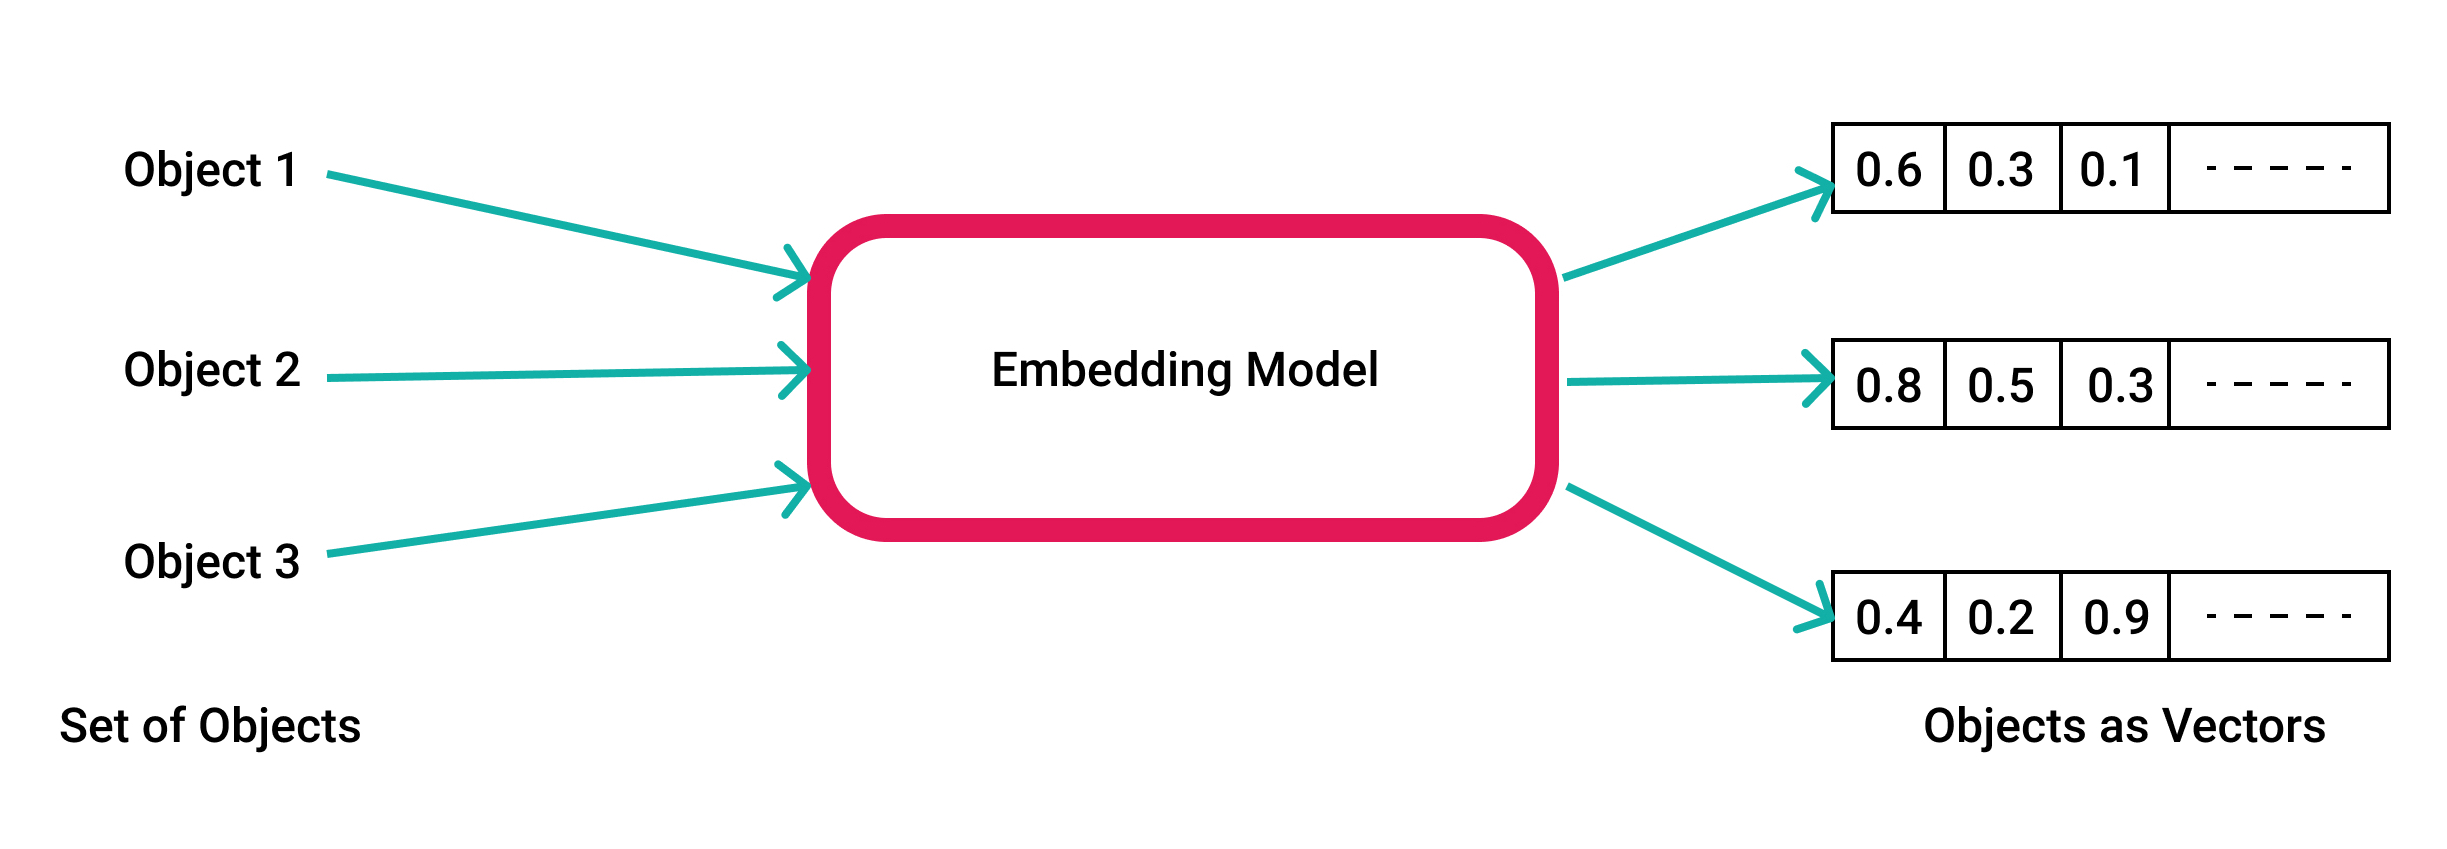
##### Image Source: [Pinecone](https://www.pinecone.io/learn/vector-embeddings/)


For this project we are using the `bert-base-nli-mean-tokens` sentence transformer model from Hugging Face, to perform a semantic similarity query  between our data objects (Courses), based on the course title, description and department. This model produces a vector embedding of 768 dimensions. 


In [38]:
model_in = 'bert-base-nli-mean-tokens'

In [39]:
model =  SentenceTransformer(model_in)

In [1]:
sample_vec_str = 'Introduction to 3D Computer Animation  A basic overview of the 3D animation production process, including modeling, texturing, rigging, animation, lighting, and rendering. A-F only. Pre: 255 (or concurrent). Academy for Creative Media (ACM)'
sample_vec_str

'Introduction to 3D Computer Animation  A basic overview of the 3D animation production process, including modeling, texturing, rigging, animation, lighting, and rendering. A-F only. Pre: 255 (or concurrent). Academy for Creative Media (ACM)'

In [40]:
sample_vec_embedding = model.encode([sample_vec_str])
sample_vec_embedding

array([[-2.52087355e-01,  1.02398765e+00,  5.17892659e-01,
         2.07182214e-01,  4.35276628e-01, -5.65324664e-01,
         2.43495852e-01,  1.04079813e-01,  1.07276745e-01,
        -1.10397279e-01, -1.28311947e-01,  2.53727049e-01,
         6.35129213e-01,  1.64745733e-01, -4.68095332e-01,
         4.60112840e-01, -7.58652031e-01, -7.14574516e-01,
         8.62229839e-02, -2.11045474e-01, -5.14945686e-01,
        -1.15580881e+00, -1.76512137e-01,  6.18724763e-01,
        -4.47163619e-02,  1.74594522e-01,  4.94724244e-01,
         5.24668813e-01, -4.28189695e-01, -3.43036622e-01,
        -8.43809128e-01,  1.74863562e-01,  6.21227324e-01,
        -8.08930516e-01,  5.56665719e-01,  6.68312371e-01,
         6.12137467e-02,  7.24730730e-01,  5.75876355e-01,
         3.36582184e-01, -1.46078944e-01, -2.38020971e-01,
         4.99893308e-01, -5.25775373e-01, -1.11525130e+00,
        -1.29245088e-01,  2.49865115e-01,  2.69043475e-01,
        -3.05328984e-02, -2.65406996e-01, -4.82159376e-0

In [42]:
sample_vec_embedding.shape

(1, 768)

### Vector Similarity Search: kNN and ANN

Our vector database uses an index to store the vector embeddings we intend to search. The purpose of the search is to locate and return vectorized objects similar to that of our vectorized query. The primary trade-offs to consider when selecting an index are: speed search (latency) and search quality (recall). An additional consideration is that of cost in terms of memory. 

K nearest neighbor (kNN), a popular vector search algorithm, provides excellent accuracy in a search. kNN calculates the distance between the query vector and every vector within the database to return the closest k neighbors. kNN is a flat (brute force) index approach. The issue with kNN is that it scales linearly depending on the size of the dataset. A search query will take O(N) time, since all vectors embedding are considered. This is not ideal given the large sizes of dataset often seen in big data. 

To make search faster on large datasets, vector size can be reduced and/or search scope can be reduced. In either approach we sacrifice search accuracy for the sake of speed, to perform an Approximate Nearest Neighbor (ANN) search. 

There are several algorithms available to implement ANN including: Spotify’s [ANNOY](https://github.com/spotify/annoy) (Approximate Nearest Neighbors Oh Yeah) a tree-based ANN search, Facebook’s [FAISS](https://github.com/facebookresearch/faiss) (Facebook AI Similarity Search) a cluster- based ANN search, and HNSW (Hierarchical Navigable Small Worlds) a graph-based ANN search.

### Vector Index: Hierarchical Navigable Small World (HNSW):

Weavaite’s default index vector type is a customized HNSW implementation of ANN. HNSW is a top performing index for vector similarity search that delivers both fast search speeds and quality recall. 

The original paper for HNSW can be found [here](https://arxiv.org/ftp/arxiv/papers/1603/1603.09320.pdf). In summary, HNSW graphs are a Navigable Small World (NSW) modified to include the layer structure of a probability skip list. Navigable small world models are defined as any network with (poly/)logarithmic complexity using greedy routing.  As a proximity graph, NSW structures contain both long-range and short-range link lengths, and each node has knowledge of their (local) neighbors in a ‘friend list’ .The link length variation produces the logarithmic search complexity. Hierarchical Navigable Small Worlds graphs, as evidenced by the name, extends the idea of a navigable small world by adding hierarchy based on the length of the links between the nodes where the top layer contains the longest links and the bottom layer contains the shortest. 

A search within an HSNW graph begins at the top layer (entry layer) with the longest links. This is a global search of the network; with the fewest nodes to consider. We traverse the entry layer until we find the local minimum, which is the node in that particular layer that is ‘closest’ to our query. We then follow that node to the next, more densely connected  sub-layer, for the local minimum. This process continues until we reach the base layer 0, and find the nearest neighbor to our vector query. 


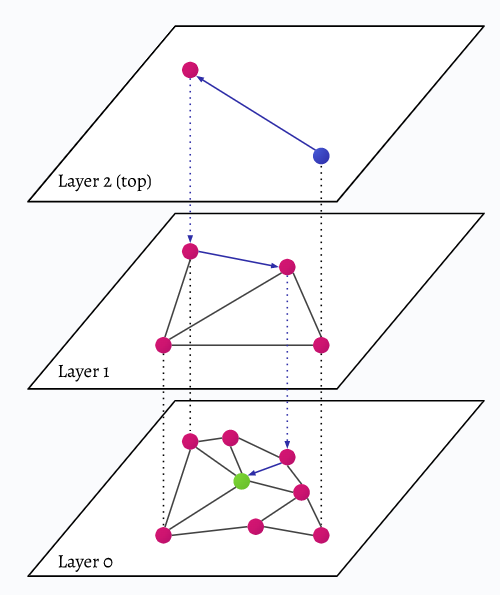

Weaviate allows for custom configuration of HNSW. Several distance metrics are supported including: Euclidean distance (l2-squared), Hamming and Manhattan. The default distance metric is cosine distance. Several other HSNW parameters can be custom configured for optimization including: <br>


`ef `: The number of entry points explored between layers during the search<br>
`efConstruction`: The number of entry points explored during index construction <br>
`maxConnections`: The maximum number of neighbors each node will connect to <br>

The `ef`, `efConstruction` and `maxConnection` parameters can be increased to improve the search quality. However, search quality is improved at the cost of time. Increasing `ef` and `maxConnection` for the sake of accuracy will also increase the query time. Increasing `efConstruction`, increases construction time. Weavaite documentation provides an in-depth exploration of the parameter effect on performance, [here](https://weaviate.io/developers/weaviate/current/benchmarks/ann.html#sift1m-1m-128d-vectors-l2-distance).

<b> Given the relatively small size of our demo dataset, we utilize the default index setting set by Weaviate in our database. </b>


### Filtered Vector Search

In general, there are two approaches to filtering a vector search based on its associated metadata: pre-filtering vs post-filtering. 

In post-filtering, the vector search query is performed first and metadata filters are applied to the resulting vector search query. The pitfall of this approach is that given the results of the vector query, there may not exist any results that fit the criteria of the subsequent filter. In other words, no matches are returned, even though matches could exist somewhere in the dataset. 

Pre-filtering provides a solution to the problem mentioned above. In pre-filtering the metadata filters are applied first ensuring that there will be matches that fit the filter criteria, then the ANN vector search is applied to the restricted (pre-filtered) data. Note, in some of the literature on pre-filtering vector searches, it is stated that once the data is pre-filtered the vector search must be conducted in a brute force manner, losing the efficiency of approximation. This is not the case for Weaviat’es pre-filter search.

As noted earlier in the ‘Architecture Overview’, Weaviate’s inverted index is next to the HNSW index in storage. This configuration allows for an efficient pre-filter search process where , according to the [documentation](https://weaviate.io/developers/weaviate/current/architecture/prefiltering.html):

1. An inverted index (similar to a traditional search engine) is used to create an allow-list of eligible candidates. This list is essentially a list of uint64 ids, so it can grow very large without sacrificing efficiency.


2. A vector search is performed where the allow-list is passed to the HNSW index. The index will move along any node’s edges normally, but will only add ids to the result set that are present on the allow list. The exit conditions for the search are the same as for an unfiltered search: The search will stop when the desired limit is reached and additional candidates no longer improve the result quality.

In other words, pre-filtering in Weaviate, maintains the vector search efficiency of the HNSW, Approximate Nearest Neighbor implementation; preserving both the recall (~80% and above)  and latency (sub 50 ms) performance of the query. Weaviate also implements a ‘Flat-Search Cutoff’, where the vector search automatically switches to a flat search to enhance performance. The default cutoff is ~15% of the dataset size. The logic being that if a filtered search is already restricted to 15% of the dataset size, HNSW (ANN) performance is closer to that of a flat search (KNN); and therefore it is more efficient to switch to a flat search outright.
 
A full exploration of effects of prefiltering on recall and latency performance can be viewed here. Within Weaviate, the cutoff can be configured in the `vectorIndexConfig` settings. 

<b> For the sake of this demonstration, we use the default cutoff setting. </b>


# Demo and Visualization

In this section we create our Weaviate vector database and provide visualizations of our vector embeddings.

#### Code: Library Installs and Imports

In [1]:
import sys
!{sys.executable} -m pip install weaviate-client==3.0.0
!{sys.executable} -m pip install torch 
!{sys.executable} -m pip install transformers 
!{sys.executable} -m pip install sentence-transformers
!{sys.executable} -m pip install nltk 
!{sys.executable} -m pip install tqdm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from getpass import getpass
import weaviate
from weaviate.wcs import WCS
from weaviate.batch import Batch
import torch
import uuid
import tqdm
import numpy as np
import csv
import re
import json
import pandas as pd
from tqdm.notebook import trange, tqdm
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from transformers import AutoModel, AutoTokenizer
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer

##viz
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#### Code: Data Scrape Utility Function Import and Data Scrape
Note: The cells in this section do not need to run since the resulting data frame is provided in the `data\` folder and read in later ; however if you wish to scrape the data yourself you can do so by running these cells. Functionality demonstrated in `working_draft.ipynb` in [Github repo](https://github.com/CS-Edwards/vector_search_engine/blob/main/working_draft.ipynb).

Be advised that some cells take over 5 mins to execute as they are scraping over 12k course descriptions from the university web site. 


In [25]:
from google.colab import files
open('code/data_util.py','wb')
import data_util

In [26]:
from data_util import get_all_links, trim_link, course_num_title, pull_course_reg, pull_course_desc #utility functions 

In [27]:
reg_url = 'https://www.sis.hawaii.edu/uhdad/avail.classes?i=MAN&t=202330'
raw_reg = get_all_links(reg_url,'div',"columns")
raw_reg[:10]

['./avail.classes?i=MAN&t=202330&s=ACM',
 './avail.classes?i=MAN&t=202330&s=ACC',
 './avail.classes?i=MAN&t=202330&s=AS',
 './avail.classes?i=MAN&t=202330&s=ASL',
 './avail.classes?i=MAN&t=202330&s=AMST',
 './avail.classes?i=MAN&t=202330&s=ANAT',
 './avail.classes?i=MAN&t=202330&s=ANSC',
 './avail.classes?i=MAN&t=202330&s=ANTH',
 './avail.classes?i=MAN&t=202330&s=ARAB',
 './avail.classes?i=MAN&t=202330&s=ARCH']

In [28]:
reg_url_list = trim_link(raw_reg)
print(len(reg_url_list))
reg_url_list[:10]

158


['/avail.classes?i=MAN&t=202330&s=ACM',
 '/avail.classes?i=MAN&t=202330&s=ACC',
 '/avail.classes?i=MAN&t=202330&s=AS',
 '/avail.classes?i=MAN&t=202330&s=ASL',
 '/avail.classes?i=MAN&t=202330&s=AMST',
 '/avail.classes?i=MAN&t=202330&s=ANAT',
 '/avail.classes?i=MAN&t=202330&s=ANSC',
 '/avail.classes?i=MAN&t=202330&s=ANTH',
 '/avail.classes?i=MAN&t=202330&s=ARAB',
 '/avail.classes?i=MAN&t=202330&s=ARCH']

In [29]:
#UH Manoa Spring '23 Course Catalog Description by Department
desc_url = 'https://manoa.hawaii.edu/catalog/courses-overview/'
desc_list = get_all_links(desc_url,'ul',"course-directory")
desc_list[:10]

['https://manoa.hawaii.edu/catalog/category/arts-languages-letters/acm/',
 'https://manoa.hawaii.edu/catalog/category/business/acc/',
 'https://manoa.hawaii.edu/catalog/category/rotc/as/',
 'https://manoa.hawaii.edu/catalog/category/ctahr/nrem/arec/',
 'https://manoa.hawaii.edu/catalog/category/arts-languages-letters/ling/asl/',
 'https://manoa.hawaii.edu/catalog/category/arts-languages-letters/amst/',
 'https://manoa.hawaii.edu/catalog/category/jabsom/abprb/anat/',
 'https://manoa.hawaii.edu/catalog/category/jabsom/abprb/',
 'https://manoa.hawaii.edu/catalog/category/ctahr/humannuti/ansc/',
 'https://manoa.hawaii.edu/catalog/category/social-sciences/anth/']

In [30]:
print(len(desc_list))

216


In [31]:
with open('data/dept_desc_list.csv', 'w') as f:
    write = csv.writer(f)    
    write.writerows(desc_list)

In [32]:
full_reg_list = list()

reg_root = 'https://www.sis.hawaii.edu/uhdad'
reg_url = reg_root + reg_url_list[0]
print(reg_url)

https://www.sis.hawaii.edu/uhdad/avail.classes?i=MAN&t=202330&s=ACM


In [33]:
for i, dept in tqdm(enumerate(reg_url_list)):
  reg_url = reg_root + reg_url_list[i]
  pull_course_reg(reg_url,full_reg_list)



0it [00:00, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
with open('data/reg_list.csv', 'w') as f:
    write = csv.writer(f)
    write.writerows(full_reg_list)

In [ ]:
#all course descriptions from catalog
full_course_desc_list = list()

#(Over 4 mins to run) over 12k course descriptions
for dept in desc_list:
  pull_course_desc(dept,full_course_desc_list)
  print(len(full_course_desc_list))

In [ ]:
#description list to dataframe
df_desc = pd.DataFrame (full_course_desc_list, columns = ['course','course_name','description'])
df_desc

In [ ]:
#registration list dataframe
reg_col = ['GenEd/Focus/Special Des.','CRN','course','Section','Title','Credits','Instructor', 'Curr.Enrolled','Seatsavail','Curr.Waitlisted','Waitavail.','Days','Time','Room','Dates','Department']
df_reg = pd.DataFrame (full_reg_list, columns = reg_col)  #change var to full_reg_list
df_reg

In [ ]:
#merge dataframes

inner_join = pd.merge(df_reg,df_desc, on='course', how='inner')
inner_join

In [ ]:
inner_join.info(memory_usage="deep")

In [ ]:
data = inner_join[['course','Credits','Instructor','Department','course_name','description']].copy()
data

In [ ]:
data.info(memory_usage="deep")

In [ ]:
data= data.drop_duplicates()

In [ ]:
data.info(memory_usage="deep")

In [ ]:
data['vec_str'] = data[['course_name','description','Department']].agg(" ".join,axis=1) #to list --> into encoding model --> expected shape (57,768)

## Data and Vectors

This section contains the data we will work with to create our vector database. 
 


### Data:
`data` contains the resulting dataframe from scraping the University of Hawaii Manoa course descriptions and Spring ‘23 registration pages for relevant information. After the data was scraped from the site, the registration and description dataframes were inner joined on the `course`,and then de-duplicated. The final dataframe was saved to a csv from the `working_draft.ipynb` linked above and loaded into this notebook for ease of use.  
 
Note: Courses with the same `course_name` and `course` with different `Instructor` are not considered duplicates(ie. `ACM 310` in the dataframe).

In [3]:
data = pd.read_csv('data/data_df.csv')
data

,Unnamed: 0,course,Credits,Instructor,Department,course_name,description,vec_str
0,0,ACM 215,3,J F Parente,Academy for Creative Media (ACM),Introduction to 3D Computer Animation,A basic overview of the 3D animation productio...,Introduction to 3D Computer Animation A basic...
1,4,ACM 216,3,L Margulies,Academy for Creative Media (ACM),Fundamentals of Animation,Introduction to traditional styles and methods...,Fundamentals of Animation Introduction to tra...
2,8,ACM 255,3,A H Ladner,Academy for Creative Media (ACM),Introduction to Cinema and Digital Media,"Introduction to the study of cinema: history, ...",Introduction to Cinema and Digital Media Intr...
3,16,ACM 310,3,S E Schimmel,Academy for Creative Media (ACM),Cinematic Narrative Production,Production-intensive course with collaborative...,Cinematic Narrative Production Production-int...
4,18,ACM 310,3,F Titz,Academy for Creative Media (ACM),Cinematic Narrative Production,Production-intensive course with collaborative...,Cinematic Narrative Production Production-int...
...,...,...,...,...,...,...,...,...
2460,11240,ZOOL 710,2-4,M A Butler,Zoology (ZOOL),Topics in Biometry,Selected advanced topics in experimental desig...,Topics in Biometry Selected advanced topics i...
2461,11246,ZOOL 719,1-6,P B Marko,Zoology (ZOOL),Topics in Systematics and Evolution,Selected problems of current or historic inter...,Topics in Systematics and Evolution Selected ...
2462,11249,ZOOL 719,1-6,K Cole,Zoology (ZOOL),Topics in Systematics and Evolution,Selected problems of current or historic inter...,Topics in Systematics and Evolution Selected ...
2463,11252,ZOOL 719,1-6,M A Butler,Zoology (ZOOL),Topics in Systematics and Evolution,Selected problems of current or historic inter...,Topics in Systematics and Evolution Selected ...


### Vectors:

The `vec_str` column is a concat of the `course_name`,`description`, and `Department`. The text in the `vec_str` column is used to create the vector embedding.

As mentioned above, we will use Hugging Face's sentence transformed `` to vectorize the data. 

In [34]:
data.vec_str[1]

'Fundamentals of Animation  Introduction to traditional styles and methods of hand drawn 2D, digital, and stop motion animation through theory and practice. A-F only. Pre: 255 (or concurrent) and ART 113, or consent. Academy for Creative Media (ACM)'

In [35]:
course_vecs_list = data['vec_str'].values.tolist()

In [36]:
len(course_vecs_list)

2465

In [37]:
course_vecs_list[:5]


['Introduction to 3D Computer Animation  A basic overview of the 3D animation production process, including modeling, texturing, rigging, animation, lighting, and rendering. A-F only. Pre: 255 (or concurrent). Academy for Creative Media (ACM)',
 'Fundamentals of Animation  Introduction to traditional styles and methods of hand drawn 2D, digital, and stop motion animation through theory and practice. A-F only. Pre: 255 (or concurrent) and ART 113, or consent. Academy for Creative Media (ACM)',
 'Introduction to Cinema and Digital Media  Introduction to the study of cinema: history, aesthetics, and cultural impact. A-F only. Academy for Creative Media (ACM)',
 'Cinematic Narrative Production  Production-intensive course with collaborative as well as individual projects. Theories and application of basic digital cinema productions, including camera, lighting, sound, and editing. ACM majors only. A-F only. Pre: 255 (or concurrent). Academy for Creative Media (ACM)',
 'Cinematic Narrative P

#### Vector Embeddings:

The following cell creates embeddings for the 2465 documents in the `course_vec_list`. Running this cell takes approximately 15 mins. 

The embeddings were generated in a previous run of this model in `working_draft,ipynb` and saved as `embeddings.npy`, in the `data/` folder. 

In [45]:
#course_vecs = model.encode(course_vecs_list)

In [4]:
course_vecs = np.load('data/embeddings.npy')

In [5]:
course_vecs.shape

(2465, 768)

## Course Object and Schema

-----about object----

In [6]:
sample_course_object = {
    'courseID':data.iloc[0]['course'],
    'courseName':data.iloc[0]['course_name'],
    'description':data.iloc[0]['description'],
    'credits':int(data.iloc[0]['Credits']), #cast as int for schema
    'instructor':data.iloc[0]['Instructor'],
    'department':data.iloc[0]['Department']

}
sample_course_object

{'courseID': 'ACM 215',
 'courseName': 'Introduction to 3D Computer Animation ',
 'description': 'A basic overview of the 3D animation production process, including modeling, texturing, rigging, animation, lighting, and rendering. A-F only. Pre: 255 (or concurrent).',
 'credits': 3,
 'instructor': 'J F Parente',
 'department': 'Academy for Creative Media (ACM)'}

### Schema:

--about schema--

In [7]:
course_schema = {
     "classes": [{
                    "class": "Course",
                    "description": "A Course class to store: course_name, description, credits, instructor, department",
                    "vectorizer": "none", # explicitly tell Weaviate not to vectorize anything, we are providing the vectors ourselves through our BERT model
                    "properties": [{
                        "dataType": [
                          "string"
                        ],
                        "description": "The deptarment and number of the course",
                        "name": "courseID"
                      },
                      {
                        "dataType": [
                          "text"
                        ],
                        "description": "The course description from catalog",
                        "name": "description"
                      },{
                        "dataType": [
                          "string"
                        ],
                        "description": "The name of the course",
                        "name": "courseName"
                      },
                      {
                        "dataType": [
                          "int"
                        ],
                        "description": "Number of credits for the course",
                        "name": "credits"
                      },
                      {
                        "dataType": [
                          "string"
                        ],
                        "description": "Instructor of this course",
                        "name": "instructor"
                      },
                      {
                        "dataType": [
                          "string"
                        ],
                        "description": "Academic department of this course",
                        "name": "department"
                      }]
            }]}

## Weaviate Database Instance

### Connect to Client

In [9]:
my_credentials = weaviate.auth.AuthClientPassword(username=input("User name: "), password=getpass('Password: '))


User name: cedward2@hawaii.edu
Password: ··········


In [10]:
my_wcs = WCS(my_credentials)

In [52]:
cluster_name = 'course-search-instance'
weaviate_url = my_wcs.create(cluster_name)
weaviate_url

'https://course-search-instance.semi.network'

In [53]:
my_wcs.is_ready(cluster_name)

True

In [54]:
client = weaviate.Client(weaviate_url)

In [14]:
client.schema.delete_all() # delete all classes
client.schema.get()

{'classes': []}

### Load Schema

In [15]:
client.schema.create(course_schema)

In [16]:
client.schema.get()

{'classes': [{'class': 'Course',
   'description': 'A Course class to store: course_name, description, credits, instructor, department',
   'invertedIndexConfig': {'bm25': {'b': 0.75, 'k1': 1.2},
    'cleanupIntervalSeconds': 60,
    'stopwords': {'additions': None, 'preset': 'en', 'removals': None}},
   'properties': [{'dataType': ['string'],
     'description': 'The deptarment and number of the course',
     'name': 'courseID',
     'tokenization': 'word'},
    {'dataType': ['text'],
     'description': 'The course description from catalog',
     'name': 'description',
     'tokenization': 'word'},
    {'dataType': ['string'],
     'description': 'The name of the course',
     'name': 'courseName',
     'tokenization': 'word'},
    {'dataType': ['int'],
     'description': 'Number of credits for the course',
     'name': 'credits'},
    {'dataType': ['string'],
     'description': 'Instructor of this course',
     'name': 'instructor',
     'tokenization': 'word'},
    {'dataType': [

### Load Objects

In [19]:
i=0

In [20]:
def generate_uuid_mod(class_name: str, identifier: str, int:i,
                  test: str = 'teststrong') -> str:
    """ Generate a uuid based on an identifier
    :param identifier: characters used to generate the uuid
    :type identifier: str, required
    :param class_name: classname of the object to create a uuid for
    :type class_name: str, required
    """
    test = 'overwritten'
    return str(uuid.uuid5(uuid.NAMESPACE_DNS, class_name + identifier+str(i)))

In [21]:

def add_course(batch, df,vec,i):

  #print('create object')
  try:
    course_object = {
      'courseID':df['course'],
      'courseName':df['course_name'],
      'description':df['description'],
      'credits':int(df['Credits']),
      'instructor':df['Instructor'],
      'department':df['Department']
    } 
  except ValueError:
    #print(ValueError)
    course_object = {
      'courseID':df['course'],
      'courseName':df['course_name'],      
      'description':df['description'],
      'credits':2,
      'instructor':df['Instructor'],
      'department':df['Department']
    } 

  #print('create_uuid')
  course_id = generate_uuid_mod('Course',df['course'],i)
  #print(course_id)

  #print('add to batch')


  #print(course_object)
  #print(course_id)
  #print(vec)
  try:
    batch.add_data_object(
        data_object = course_object,
        class_name = 'Course',
        uuid = course_id,
        vector = vec
    )
  except:    
    print('UnexpectedStatusCodeException')
    print(course_object, course_id)
    pass


  


**Test Load**

In [23]:
sample_course_object

{'courseID': 'ACM 215',
 'courseName': 'Introduction to 3D Computer Animation ',
 'description': 'A basic overview of the 3D animation production process, including modeling, texturing, rigging, animation, lighting, and rendering. A-F only. Pre: 255 (or concurrent).',
 'credits': 3,
 'instructor': 'J F Parente',
 'department': 'Academy for Creative Media (ACM)'}

In [24]:
course_id = generate_uuid_mod('Course',data.iloc[0]['course'],0)
course_id

'20c5e769-dc6f-5a1a-aa40-8468732e4a16'

In [25]:
#validate object
result = client.data_object.validate(
    data_object=sample_course_object,
    class_name='Course',
    uuid = course_id,
    
)

In [26]:
result

{'error': None, 'valid': True}

In [27]:
client.data_object.create(
    data_object=sample_course_object,
    class_name='Course',
    uuid = course_id,
    vector = course_vecs[0]
)

'20c5e769-dc6f-5a1a-aa40-8468732e4a16'

In [28]:
#Successful load ; uuid returned (above)
#query db by uuid to view 
client.data_object.get(course_id, with_vector=False)


{'class': 'Course',
 'creationTimeUnix': 1670912718445,
 'id': '20c5e769-dc6f-5a1a-aa40-8468732e4a16',
 'lastUpdateTimeUnix': 1670912718445,
 'properties': {'courseID': 'ACM 215',
  'courseName': 'Introduction to 3D Computer Animation ',
  'credits': 3,
  'department': 'Academy for Creative Media (ACM)',
  'description': 'A basic overview of the 3D animation production process, including modeling, texturing, rigging, animation, lighting, and rendering. A-F only. Pre: 255 (or concurrent).',
  'instructor': 'J F Parente'},
 'vectorWeights': None}



---



In [29]:
client.batch.configure(
    batch_size = 100,
    callback = None
)

In [30]:
batch = client.batch

In [31]:
for i in range(len(data)):
  add_course(batch,data.iloc[i],course_vecs[i],i)


UnexpectedStatusCodeException
{'courseID': 'ITM 699', 'courseName': 'Directed Research ', 'description': 'Reading and research in ITM under the direction of a faculty member. Repeatable unlimited times. A-F only.', 'credits': 2, 'instructor': 'T Bui', 'department': 'Information Technology Mgt (ITM)'} 93b5b1eb-264f-5585-aba0-c7b836688317
UnexpectedStatusCodeException
{'courseID': 'ICS 101', 'courseName': 'Digital Tools for the Information World ', 'description': 'Fundamental information technology concepts and computing terminology, productivity software for problem solving, computer technology trends and impact on individuals and society. Emphasizes the utilization of operating systems and the production of professional documents, spreadsheets, etc.', 'credits': 4, 'instructor': 'M C Ogawa', 'department': 'Information& Computer Sciences (ICS)'} cd77fc9b-229d-57fb-8df6-c583f6378323
UnexpectedStatusCodeException
{'courseID': 'ICS 111', 'courseName': 'Introduction to Computer Science I ',

In [35]:
result = client.query.get(class_name='Course', properties=["courseName","instructor"])\
    .with_limit(3000)\
    .do()

In [33]:
print(type(result))

<class 'dict'>


In [36]:
print(f"Number of courses returned: {len(result['data']['Get']['Course'])}")
#result

Number of courses returned: 1100


## Semantic Search Queries
Python client and via Weaviate Console (screen shot)

In [51]:
query = 'cooking class'
q_vec = model.encode(query)

nearVec= {"vector":q_vec}
res = client.query.get(class_name='Course', properties=["courseName","instructor","department"])\
    .with_limit(5)\
    .with_near_vector(nearVec)\
    .do()

res

{'data': {'Get': {'Course': [{'courseName': 'Introduction to Food Preparation ',
     'department': 'Food Science & Human Nutrition (FSHN)',
     'instructor': 'L J Hackney'},
    {'courseName': 'Food, Culture, and Empire in U.S. and Hawai‘i ',
     'department': 'Ethnic Studies (ES)',
     'instructor': 'M Koikari'},
    {'courseName': 'Food, Health, and Society ',
     'department': 'Anthropology (ANTH)',
     'instructor': 'E Saethre'},
    {'courseName': 'Food Preparation Lab ',
     'department': 'Food Science & Human Nutrition (FSHN)',
     'instructor': 'L J Hackney'},
    {'courseName': 'Field Experience ',
     'department': 'Food Science & Human Nutrition (FSHN)',
     'instructor': 'S L Breshears'}]}}}

In [60]:
query = 'climate change'
q_vec = model.encode(query)

nearVec= {"vector":q_vec}
res = client.query.get(class_name='Course', properties=["courseName","instructor","department"])\
    .with_limit(5)\
    .with_near_vector(nearVec)\
    .do()

res

{'data': {'Get': {'Course': [{'courseName': 'Environment, Resources and Society ',
     'department': 'Geography & Environment (GEO)',
     'instructor': 'S Kandikuppa'},
    {'courseName': 'Tropical Climate and Weather ',
     'department': 'Atmospheric Sciences (ATMO)',
     'instructor': 'Y Wang'},
    {'courseName': 'Stable Isotope Biogeochemistry ',
     'department': 'Earth Sciences (ERTH)',
     'instructor': 'B Popp'},
    {'courseName': 'Applied Atmospheric Dynamics ',
     'department': 'Atmospheric Sciences (ATMO)',
     'instructor': 'Y Chen'},
    {'courseName': 'Sedimentary Geochemistry ',
     'department': 'Earth Sciences (ERTH)',
     'instructor': 'K C Ruttenberg'}]}}}

Click [here](https://link.semi.technology/3WeEsQC) to the sample query live from the Weavaite Console.

Snapshot of the Sample Query:
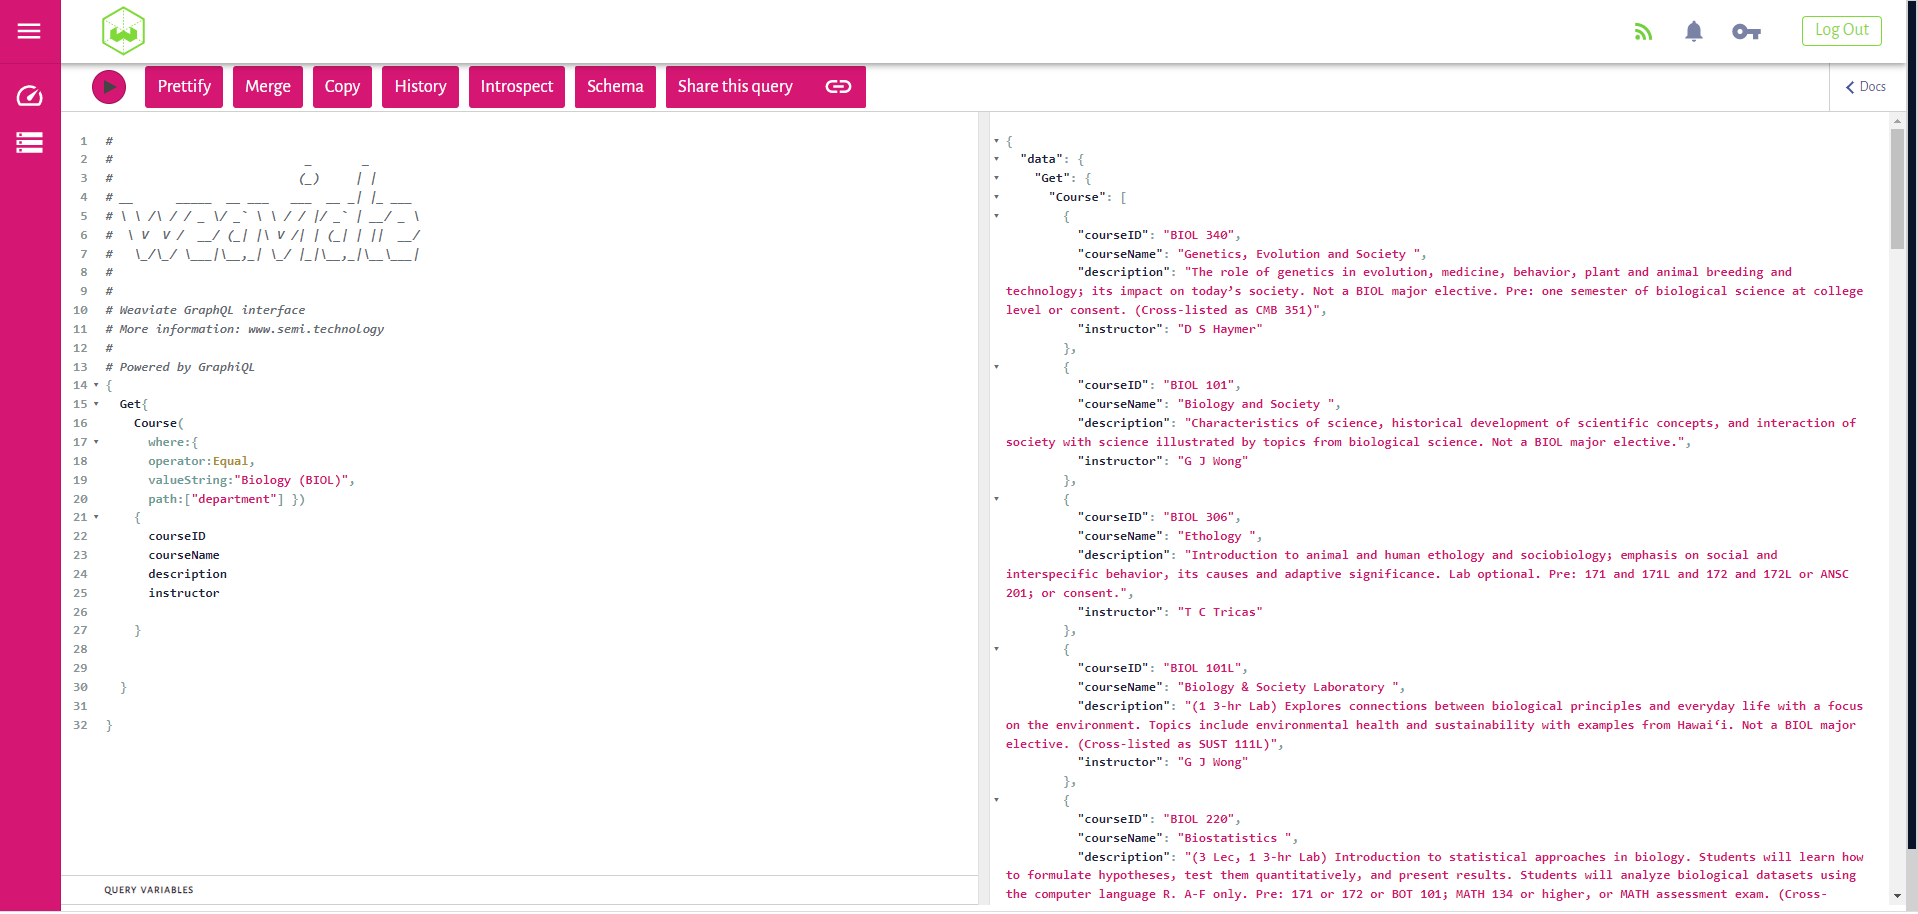

## Visualizations: PCA and T-SNE